## Experiment tracking with PyTorch

In [23]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from module import setup_data, engine
from torchinfo import summary
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from typing import Dict, List
from tqdm.auto import tqdm
from module.engine import model_training, model_testing
from datetime import datetime
import os
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
from module.utils import save_model
from module.prediction import pred_and_plot_image
import random

In [7]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cpu
torchvision version: 0.16.0+cpu


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1. Data preparation

In [9]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [10]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
image_path_20 = data_path / "pizza_steak_sushi_20_percent"

#### 1. 1 Create dataloader using manually created transform

In [11]:
train_path = image_path / "train"
test_path = image_path / "test"

normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           

print(f"Manually created transforms: {manual_transform}")

train_dataloader, test_dataloader, class_name = setup_data.create_dataloader(
    train_path = train_path,
    test_path = test_path,
    transform = manual_transform,
    batch_size = 32
)

train_dataloader, test_dataloader, class_name

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x1dc72933c70>,
 ['pizza', 'steak', 'sushi'])

#### 1.2 Create dataloader using automatically created transform

In [12]:
train_path = image_path / "train"
test_path = image_path / "test"

weight = torchvision.models.EfficientNet_B0_Weights.DEFAULT
automatic_transform = weight.transforms() 

print(f"Automatically created transform: {automatic_transform}")

train_dataloader, test_dataloader, class_name = setup_data.create_dataloader(
    train_path = train_path,
    test_path = test_path,
    transform = automatic_transform,
    batch_size = 32
)

train_dataloader, test_dataloader, class_name

Automatically created transform: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x1dc728c9700>,
 ['pizza', 'steak', 'sushi'])

### 2. Model building

First model testing

In [8]:
model = torchvision.models.efficientnet_b0(weights = weight).to(device)

for param in model.features.parameters():
    param.requires_grad = False

set_seed()

model.classifier = torch.nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, out_features = len(class_name), bias = True).to(device))

In [9]:
summary(model, input_size = (32, 3, 224, 224), verbose = 0, 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 13, row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape   Output Shape  Param #       Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 3]       --            Partial
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --            False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --            False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] (864)         False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] (64)          False
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --            --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --            False
│    │    └─MBConv (0)                                       [32, 

In [10]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [11]:
writer = SummaryWriter()

In [12]:
def start_training(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
          loss_function: torch.nn.Module, epoch_number: int, device: torch.device) -> Dict[str, List]:
    result = {"train_loss": [], "train_accuracy": [],
               "test_loss": [], "test_accuracy": []
    }

    for epoch in tqdm(range(epoch_number)):
        train_loss, train_accuracy = model_training(model = model,
                                           dataloader = train_dataloader,
                                           loss_function = loss_function,
                                           optimizer = optimizer,
                                           device = device)
        test_loss, test_accuracy = model_testing(model = model,
                                        dataloader = test_dataloader,
                                        loss_function = loss_function,
                                        device = device)

        print(
          f"Epoch: {epoch + 1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_accuracy: {train_accuracy:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_accuracy: {test_accuracy:.4f}"
        )

        result["train_loss"].append(train_loss)
        result["train_accuracy"].append(train_accuracy)
        result["test_loss"].append(test_loss)
        result["test_accuracy"].append(test_accuracy)

        writer.add_scalars(main_tag = "Loss", 
                           tag_scalar_dict = {"train_loss": train_loss, "test_loss": test_loss},
                           global_step = epoch)

        writer.add_scalars(main_tag = "Accuracy", 
                           tag_scalar_dict = {"train_accuracy": train_accuracy, "test_accuracy": test_accuracy}, 
                           global_step = epoch)
        
        writer.add_graph(model = model, input_to_model = torch.randn(32, 3, 224, 224).to(device))
    
    writer.close()
    
    return result

In [13]:
set_seed()

result = start_training(model = model,
                train_dataloader = train_dataloader,
                test_dataloader = test_dataloader,
                optimizer = optimizer,
                loss_function = loss_function,
                epoch_number = 5,
                device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_accuracy: 0.3867 | test_loss: 0.8843 | test_accuracy: 0.6828


 20%|██        | 1/5 [00:34<02:17, 34.32s/it]

Epoch: 2 | train_loss: 0.9204 | train_accuracy: 0.6445 | test_loss: 0.8134 | test_accuracy: 0.7746


 40%|████      | 2/5 [01:09<01:44, 34.87s/it]

Epoch: 3 | train_loss: 0.7602 | train_accuracy: 0.8750 | test_loss: 0.6562 | test_accuracy: 0.8864


 60%|██████    | 3/5 [01:46<01:11, 35.90s/it]

Epoch: 4 | train_loss: 0.6868 | train_accuracy: 0.7695 | test_loss: 0.6201 | test_accuracy: 0.8759


 80%|████████  | 4/5 [02:22<00:35, 35.93s/it]

Epoch: 5 | train_loss: 0.6467 | train_accuracy: 0.7969 | test_loss: 0.6054 | test_accuracy: 0.8665


100%|██████████| 5/5 [02:58<00:00, 35.66s/it]


In [14]:
result

{'train_loss': [1.096598967909813,
  0.9203867614269257,
  0.7602226883172989,
  0.6868081130087376,
  0.6466987803578377],
 'train_accuracy': [0.38671875, 0.64453125, 0.875, 0.76953125, 0.796875],
 'test_loss': [0.8842612902323405,
  0.8134126663208008,
  0.6561941703160604,
  0.6200586160024008,
  0.6053727666536967],
 'test_accuracy': [0.6827651515151515,
  0.774621212121212,
  0.8863636363636364,
  0.8759469696969697,
  0.8664772727272728]}

In [15]:
# %load_ext tensorboard
# %tensorboard --logdir runs

Another model training

In [16]:
def create_writer(experiment_name: str, model_name: str, 
                  extra: str = None) -> torch.utils.tensorboard.writer.SummaryWriter():
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    
    return SummaryWriter(log_dir = log_dir)

In [17]:
example_writer = create_writer(experiment_name = "data_10_percent", model_name = "effnetb0",
                               extra = "5_epoch")

[INFO] Created SummaryWriter, saving to: runs\2023-11-22\data_10_percent\effnetb0\5_epoch...


In [18]:
def start_training(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
          loss_function: torch.nn.Module, epoch_number: int, device: torch.device,
                   writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    result = {"train_loss": [], "train_accuracy": [],
               "test_loss": [], "test_accuracy": []
    }

    for epoch in tqdm(range(epoch_number)):
        train_loss, train_accuracy = model_training(model = model,
                                           dataloader = train_dataloader,
                                           loss_function = loss_function,
                                           optimizer = optimizer,
                                           device = device)
        test_loss, test_accuracy = model_testing(model = model,
                                        dataloader = test_dataloader,
                                        loss_function = loss_function,
                                        device = device)
        
        print(
          f"Epoch: {epoch + 1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_accuracy: {train_accuracy:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_accuracy: {test_accuracy:.4f}"
        )

        result["train_loss"].append(train_loss)
        result["train_accuracy"].append(train_accuracy)
        result["test_loss"].append(test_loss)
        result["test_accuracy"].append(test_accuracy)

        if writer:
            writer.add_scalars(main_tag = "Loss", tag_scalar_dict = {"train_loss": train_loss, "test_loss": test_loss},
                               global_step = epoch)
            writer.add_scalars(main_tag = "Accuracy", tag_scalar_dict = {"train_accuracy": train_accuracy, "test_accuracy": test_accuracy}, 
                               global_step = epoch)
            writer.close()
        else:
            pass
    
    return result

In [20]:
train_path_10_percent = image_path / "train"
train_path_20_percent = image_path_20 / "train"
test_path = image_path / "test"

print(f"Training directory 10%: {train_path_10_percent}")
print(f"Training directory 20%: {train_path_20_percent}")
print(f"Testing directory: {test_path}")

Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi\test


In [20]:
# Set mean and standard deviation for [red, green, blue]
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225])

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize 
])

In [21]:
batch_size = 32

train_dataloader_10_percent, test_dataloader, class_name = setup_data.create_dataloader(train_path = train_path_10_percent,
    test_path = test_path, 
    transform = simple_transform,
    batch_size = batch_size
)

train_dataloader_20_percent, test_dataloader, class_name = setup_data.create_dataloader(train_path = train_path_20_percent,
    test_path = test_path,
    transform = simple_transform,
    batch_size = batch_size
)

print(f"Number of batches of size {batch_size} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {batch_size} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {batch_size} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_name)}, class names: {class_name}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [22]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)

WeightsEnum.get_state_dict = get_state_dict

In [23]:
effnetb2_weight = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights = effnetb2_weight)

print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB2: 1408


In [15]:
out_feature = len(class_name)
out_feature

3

In [13]:
def create_effnetb0():
    weight = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights = weight).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    set_seed()

    model.classifier = nn.Sequential(
        nn.Dropout(p = 0.2),
        nn.Linear(in_features = 1280, out_features = out_feature)
    ).to(device)

    model.name = "effnetb0"
    
    print(f"[INFO] Created new {model.name} model.")
    
    return model

def create_effnetb2():
    weight = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights = weight).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    set_seed()

    model.classifier = nn.Sequential(
        nn.Dropout(p = 0.3),
        nn.Linear(in_features = 1408, out_features = out_feature)
    ).to(device)

    model.name = "effnetb2"
    
    print(f"[INFO] Created new {model.name} model.")
    
    return model

In [26]:
effnetb0 = create_effnetb0()

summary(model = effnetb0, 
        input_size = (32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 13,
        row_settings = ["var_names"]
) 

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape   Output Shape  Param #       Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 3]       --            Partial
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] --            False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --            False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] (864)         False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] (64)          False
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --            --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --            False
│    │    └─MBConv (0)                                       [32, 

In [27]:
effnetb2 = create_effnetb2()

summary(model = effnetb2, 
        input_size = (32, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 13,
        row_settings = ["var_names"]
) 

[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape   Output Shape  Param #       Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224] [32, 3]       --            Partial
├─Sequential (features)                                      [32, 3, 224, 224] [32, 1408, 7, 7] --            False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] --            False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224] [32, 32, 112, 112] (864)         False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] (64)          False
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --            --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --            False
│    │    └─MBConv (0)                                       [32, 

In [28]:
epoch_number = [5, 10]

all_model = ["effnetb0", "effnetb2"]
train_dataloader = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [29]:
set_seed(seed = 42)

experiment_number = 0

for dataloader_name, train_dataloader in train_dataloader.items():
    for epoch in epoch_number:
        for model_name in all_model:
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epoch}")  
            
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()
            
            loss_function = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
            
            start_training(model = model,
                  train_dataloader = train_dataloader,
                  test_dataloader = test_dataloader, 
                  optimizer = optimizer,
                  loss_function = loss_function,
                  epoch_number = epoch,
                  device = device,
                  writer = create_writer(experiment_name = dataloader_name, model_name = model_name,
                                       extra = f"{epoch}_epoch"))
            
            save_filepath = f"{model_name}_07.pth"
            save_model(model = model, target_path = "saved_model/pytorch/", model_name = save_filepath)
            
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2023-11-22\data_10_percent\effnetb0\5_epoch...


 20%|██        | 1/5 [00:27<01:48, 27.17s/it]

Epoch: 1 | train_loss: 1.0564 | train_accuracy: 0.4688 | test_loss: 0.9015 | test_accuracy: 0.4782


 40%|████      | 2/5 [00:55<01:24, 28.09s/it]

Epoch: 2 | train_loss: 0.9304 | train_accuracy: 0.5547 | test_loss: 0.7984 | test_accuracy: 0.6932


 60%|██████    | 3/5 [01:23<00:56, 28.04s/it]

Epoch: 3 | train_loss: 0.8171 | train_accuracy: 0.6953 | test_loss: 0.6695 | test_accuracy: 0.8759


 80%|████████  | 4/5 [01:51<00:27, 27.86s/it]

Epoch: 4 | train_loss: 0.7350 | train_accuracy: 0.7617 | test_loss: 0.6444 | test_accuracy: 0.8864


100%|██████████| 5/5 [02:19<00:00, 27.83s/it]

Epoch: 5 | train_loss: 0.6784 | train_accuracy: 0.7656 | test_loss: 0.6367 | test_accuracy: 0.9072
[INFO] Saving model to: saved_model\pytorch\effnetb0_07.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2023-11-22\data_10_percent\effnetb2\5_epoch...


 20%|██        | 1/5 [00:33<02:15, 33.96s/it]

Epoch: 1 | train_loss: 1.0892 | train_accuracy: 0.3359 | test_loss: 0.9453 | test_accuracy: 0.7102


 40%|████      | 2/5 [01:08<01:43, 34.45s/it]

Epoch: 2 | train_loss: 0.8765 | train_accuracy: 0.7969 | test_loss: 0.8987 | test_accuracy: 0.7225


 60%|██████    | 3/5 [01:42<01:08, 34.10s/it]

Epoch: 3 | train_loss: 0.8104 | train_accuracy: 0.6992 | test_loss: 0.8249 | test_accuracy: 0.8352


 80%|████████  | 4/5 [02:16<00:33, 33.91s/it]

Epoch: 4 | train_loss: 0.6903 | train_accuracy: 0.9141 | test_loss: 0.7453 | test_accuracy: 0.8665


100%|██████████| 5/5 [02:50<00:00, 34.01s/it]

Epoch: 5 | train_loss: 0.6074 | train_accuracy: 0.8984 | test_loss: 0.6994 | test_accuracy: 0.8665
[INFO] Saving model to: saved_model\pytorch\effnetb2_07.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2023-11-22\data_10_percent\effnetb0\10_epoch...


 10%|█         | 1/10 [00:34<05:13, 34.79s/it]

Epoch: 1 | train_loss: 1.0564 | train_accuracy: 0.4688 | test_loss: 0.9015 | test_accuracy: 0.4782


 20%|██        | 2/10 [01:08<04:33, 34.17s/it]

Epoch: 2 | train_loss: 0.9304 | train_accuracy: 0.5547 | test_loss: 0.7984 | test_accuracy: 0.6932


 30%|███       | 3/10 [01:39<03:48, 32.60s/it]

Epoch: 3 | train_loss: 0.8171 | train_accuracy: 0.6953 | test_loss: 0.6695 | test_accuracy: 0.8759


 40%|████      | 4/10 [02:11<03:14, 32.49s/it]

Epoch: 4 | train_loss: 0.7350 | train_accuracy: 0.7617 | test_loss: 0.6444 | test_accuracy: 0.8864


 50%|█████     | 5/10 [02:39<02:34, 30.97s/it]

Epoch: 5 | train_loss: 0.6784 | train_accuracy: 0.7656 | test_loss: 0.6367 | test_accuracy: 0.9072


 60%|██████    | 6/10 [03:08<02:00, 30.10s/it]

Epoch: 6 | train_loss: 0.5871 | train_accuracy: 0.7891 | test_loss: 0.5834 | test_accuracy: 0.8968


 70%|███████   | 7/10 [03:36<01:28, 29.44s/it]

Epoch: 7 | train_loss: 0.6183 | train_accuracy: 0.7891 | test_loss: 0.5444 | test_accuracy: 0.8864


 80%|████████  | 8/10 [04:06<00:59, 29.61s/it]

Epoch: 8 | train_loss: 0.5403 | train_accuracy: 0.8008 | test_loss: 0.4768 | test_accuracy: 0.8968


 90%|█████████ | 9/10 [04:35<00:29, 29.54s/it]

Epoch: 9 | train_loss: 0.4885 | train_accuracy: 0.8008 | test_loss: 0.4707 | test_accuracy: 0.9176


100%|██████████| 10/10 [05:04<00:00, 30.42s/it]

Epoch: 10 | train_loss: 0.5147 | train_accuracy: 0.8086 | test_loss: 0.5353 | test_accuracy: 0.8759
[INFO] Saving model to: saved_model\pytorch\effnetb0_07.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2023-11-22\data_10_percent\effnetb2\10_epoch...


 10%|█         | 1/10 [00:36<05:27, 36.33s/it]

Epoch: 1 | train_loss: 1.0892 | train_accuracy: 0.3359 | test_loss: 0.9453 | test_accuracy: 0.7102


 20%|██        | 2/10 [01:18<05:20, 40.03s/it]

Epoch: 2 | train_loss: 0.8765 | train_accuracy: 0.7969 | test_loss: 0.8987 | test_accuracy: 0.7225


 30%|███       | 3/10 [01:55<04:28, 38.36s/it]

Epoch: 3 | train_loss: 0.8104 | train_accuracy: 0.6992 | test_loss: 0.8249 | test_accuracy: 0.8352


 40%|████      | 4/10 [02:31<03:45, 37.62s/it]

Epoch: 4 | train_loss: 0.6903 | train_accuracy: 0.9141 | test_loss: 0.7453 | test_accuracy: 0.8665


 50%|█████     | 5/10 [03:07<03:03, 36.75s/it]

Epoch: 5 | train_loss: 0.6074 | train_accuracy: 0.8984 | test_loss: 0.6994 | test_accuracy: 0.8665


 60%|██████    | 6/10 [03:46<02:31, 37.82s/it]

Epoch: 6 | train_loss: 0.6273 | train_accuracy: 0.8047 | test_loss: 0.6431 | test_accuracy: 0.8570


 70%|███████   | 7/10 [04:27<01:55, 38.64s/it]

Epoch: 7 | train_loss: 0.5653 | train_accuracy: 0.8086 | test_loss: 0.6133 | test_accuracy: 0.8769


 80%|████████  | 8/10 [05:03<01:15, 37.95s/it]

Epoch: 8 | train_loss: 0.4832 | train_accuracy: 0.9570 | test_loss: 0.5715 | test_accuracy: 0.8873


 90%|█████████ | 9/10 [05:40<00:37, 37.65s/it]

Epoch: 9 | train_loss: 0.4804 | train_accuracy: 0.9336 | test_loss: 0.5821 | test_accuracy: 0.8769


100%|██████████| 10/10 [06:17<00:00, 37.70s/it]

Epoch: 10 | train_loss: 0.4091 | train_accuracy: 0.9492 | test_loss: 0.5398 | test_accuracy: 0.8769
[INFO] Saving model to: saved_model\pytorch\effnetb2_07.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2023-11-22\data_20_percent\effnetb0\5_epoch...


 20%|██        | 1/5 [00:39<02:39, 39.76s/it]

Epoch: 1 | train_loss: 0.9652 | train_accuracy: 0.5625 | test_loss: 0.6631 | test_accuracy: 0.8655


 40%|████      | 2/5 [01:18<01:58, 39.42s/it]

Epoch: 2 | train_loss: 0.7174 | train_accuracy: 0.8146 | test_loss: 0.5644 | test_accuracy: 0.9280


 60%|██████    | 3/5 [01:58<01:18, 39.45s/it]

Epoch: 3 | train_loss: 0.5389 | train_accuracy: 0.8750 | test_loss: 0.4747 | test_accuracy: 0.9176


 80%|████████  | 4/5 [02:37<00:39, 39.42s/it]

Epoch: 4 | train_loss: 0.4867 | train_accuracy: 0.8604 | test_loss: 0.4555 | test_accuracy: 0.8873


100%|██████████| 5/5 [03:17<00:00, 39.51s/it]

Epoch: 5 | train_loss: 0.4350 | train_accuracy: 0.8896 | test_loss: 0.3677 | test_accuracy: 0.9384
[INFO] Saving model to: saved_model\pytorch\effnetb0_07.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2023-11-22\data_20_percent\effnetb2\5_epoch...


 20%|██        | 1/5 [00:50<03:23, 50.85s/it]

Epoch: 1 | train_loss: 0.9892 | train_accuracy: 0.5292 | test_loss: 0.7963 | test_accuracy: 0.8049


 40%|████      | 2/5 [01:41<02:32, 50.78s/it]

Epoch: 2 | train_loss: 0.7758 | train_accuracy: 0.7479 | test_loss: 0.6622 | test_accuracy: 0.8561


 60%|██████    | 3/5 [02:32<01:41, 50.89s/it]

Epoch: 3 | train_loss: 0.6133 | train_accuracy: 0.8333 | test_loss: 0.5939 | test_accuracy: 0.8873


 80%|████████  | 4/5 [03:23<00:50, 50.74s/it]

Epoch: 4 | train_loss: 0.4921 | train_accuracy: 0.8854 | test_loss: 0.5245 | test_accuracy: 0.9384


100%|██████████| 5/5 [04:13<00:00, 50.80s/it]

Epoch: 5 | train_loss: 0.4525 | train_accuracy: 0.8979 | test_loss: 0.4748 | test_accuracy: 0.9384
[INFO] Saving model to: saved_model\pytorch\effnetb2_07.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2023-11-22\data_20_percent\effnetb0\10_epoch...


 10%|█         | 1/10 [00:39<05:58, 39.78s/it]

Epoch: 1 | train_loss: 0.9652 | train_accuracy: 0.5625 | test_loss: 0.6631 | test_accuracy: 0.8655


 20%|██        | 2/10 [01:19<05:15, 39.50s/it]

Epoch: 2 | train_loss: 0.7174 | train_accuracy: 0.8146 | test_loss: 0.5644 | test_accuracy: 0.9280


 30%|███       | 3/10 [01:58<04:36, 39.50s/it]

Epoch: 3 | train_loss: 0.5389 | train_accuracy: 0.8750 | test_loss: 0.4747 | test_accuracy: 0.9176


 40%|████      | 4/10 [02:38<03:57, 39.54s/it]

Epoch: 4 | train_loss: 0.4867 | train_accuracy: 0.8604 | test_loss: 0.4555 | test_accuracy: 0.8873


 50%|█████     | 5/10 [03:17<03:17, 39.56s/it]

Epoch: 5 | train_loss: 0.4350 | train_accuracy: 0.8896 | test_loss: 0.3677 | test_accuracy: 0.9384


 60%|██████    | 6/10 [03:57<02:38, 39.53s/it]

Epoch: 6 | train_loss: 0.3611 | train_accuracy: 0.9292 | test_loss: 0.3761 | test_accuracy: 0.8873


 70%|███████   | 7/10 [04:36<01:58, 39.54s/it]

Epoch: 7 | train_loss: 0.3367 | train_accuracy: 0.9000 | test_loss: 0.3204 | test_accuracy: 0.9280


 80%|████████  | 8/10 [05:18<01:20, 40.17s/it]

Epoch: 8 | train_loss: 0.3353 | train_accuracy: 0.9146 | test_loss: 0.2849 | test_accuracy: 0.9280


 90%|█████████ | 9/10 [06:02<00:41, 41.28s/it]

Epoch: 9 | train_loss: 0.3535 | train_accuracy: 0.8979 | test_loss: 0.2876 | test_accuracy: 0.9384


100%|██████████| 10/10 [06:44<00:00, 40.42s/it]

Epoch: 10 | train_loss: 0.3366 | train_accuracy: 0.9021 | test_loss: 0.2915 | test_accuracy: 0.9489
[INFO] Saving model to: saved_model\pytorch\effnetb0_07.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2023-11-22\data_20_percent\effnetb2\10_epoch...


 10%|█         | 1/10 [00:52<07:55, 52.79s/it]

Epoch: 1 | train_loss: 0.9892 | train_accuracy: 0.5292 | test_loss: 0.7963 | test_accuracy: 0.8049


 20%|██        | 2/10 [01:44<06:55, 51.88s/it]

Epoch: 2 | train_loss: 0.7758 | train_accuracy: 0.7479 | test_loss: 0.6622 | test_accuracy: 0.8561


 30%|███       | 3/10 [02:35<06:01, 51.61s/it]

Epoch: 3 | train_loss: 0.6133 | train_accuracy: 0.8333 | test_loss: 0.5939 | test_accuracy: 0.8873


 40%|████      | 4/10 [03:27<05:10, 51.78s/it]

Epoch: 4 | train_loss: 0.4921 | train_accuracy: 0.8854 | test_loss: 0.5245 | test_accuracy: 0.9384


 50%|█████     | 5/10 [04:18<04:18, 51.69s/it]

Epoch: 5 | train_loss: 0.4525 | train_accuracy: 0.8979 | test_loss: 0.4748 | test_accuracy: 0.9384


 60%|██████    | 6/10 [05:09<03:25, 51.35s/it]

Epoch: 6 | train_loss: 0.4256 | train_accuracy: 0.8729 | test_loss: 0.4484 | test_accuracy: 0.9176


 70%|███████   | 7/10 [05:59<02:32, 51.00s/it]

Epoch: 7 | train_loss: 0.4224 | train_accuracy: 0.8500 | test_loss: 0.4415 | test_accuracy: 0.9280


 80%|████████  | 8/10 [06:53<01:43, 51.96s/it]

Epoch: 8 | train_loss: 0.3829 | train_accuracy: 0.8500 | test_loss: 0.3926 | test_accuracy: 0.9384


 90%|█████████ | 9/10 [07:45<00:51, 51.99s/it]

Epoch: 9 | train_loss: 0.3087 | train_accuracy: 0.9417 | test_loss: 0.4678 | test_accuracy: 0.8674


100%|██████████| 10/10 [08:36<00:00, 51.68s/it]

Epoch: 10 | train_loss: 0.3673 | train_accuracy: 0.9104 | test_loss: 0.3912 | test_accuracy: 0.9280
[INFO] Saving model to: saved_model\pytorch\effnetb2_07.pth
--------------------------------------------------



In [4]:
# %load_ext tensorboard
# %tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 23084), started 18:05:25 ago. (Use '!kill 23084' to kill it.)

In [16]:
best_model_path = "saved_model/pytorch/effnetb2_07.pth"

best_model = create_effnetb2()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [17]:
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024 * 1024)

print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


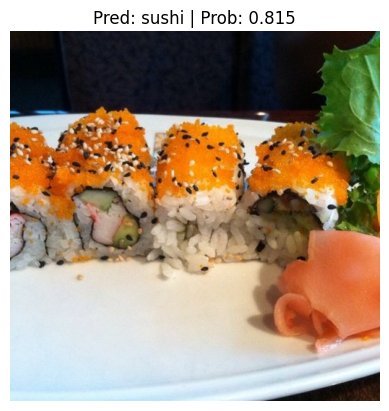

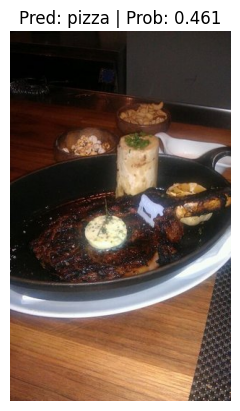

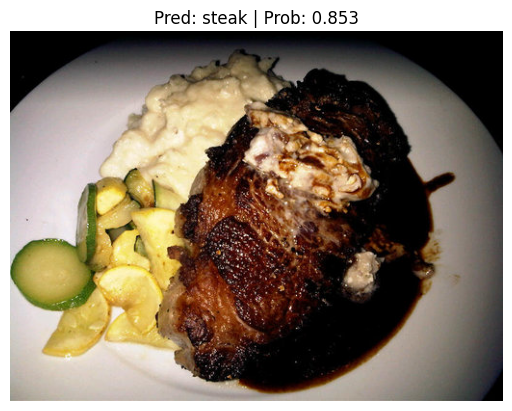

In [26]:
number_image_to_plot = 3
test_image_path_list = list(Path(image_path_20 / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(population = test_image_path_list, k = number_image_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model = best_model,
                        image_path=  image_path,
                        class_name = class_name,
                        image_size = (224, 224))

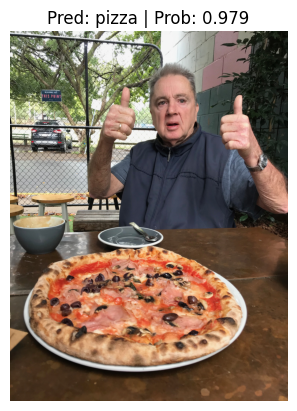

In [28]:
custom_image_path = Path("data/04-pizza-dad.jpeg")

pred_and_plot_image(model = best_model,
                    image_path = custom_image_path,
                    class_name = class_name)